In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Run the train script for each value of k
root = "/Users/michaeldoherty"  # /home/uceedoh
data_directory = f"{root}/git/XLRON/data/JOCN_SI/heuristic_benchmarks"
script_path = f"{root}/git/XLRON/xlron/train/train.py"

In [89]:
def read_rmsa_files(topology, heuristic, k, load, weighted=False):
    # Choice of traffic load - should be sufficient to cover wide range of blocking probs from <1% to 10%
    weight = "_weighted" if weighted else ""
    output_file = f"{data_directory}/kpaths/rmsa/{topology}/{heuristic}{weight}_k{k}_{load}.csv"
    df = pd.read_csv(output_file)
    return df


def read_rwa_lightpath_reuse_files(topology, heuristic, k, num_requests, first_blocking=False, weighted=False):
    weight = "_weighted" if weighted else ""
    output_file = f"{data_directory}/kpaths/rwa_lightpath_reuse/{topology}/{heuristic}{weight}_k{k}_{num_requests:.0f}{'_firstblocking' if first_blocking else ''}.csv"
    df = pd.read_csv(output_file)
    return df
             

In [4]:
# Data values for reference
env_type = "rmsa"
topologies = ["nsfnet_deeprmsa", "cost239_deeprmsa"]
heuristics = ['ksp_ff', 'ff_ksp', "ksp_bf", "bf_ksp", "kme_ff", "kmc_ff", "kmf_ff", "kca_ff"]
k_range = range(1, 11)
load_range = [50, 100, 150, 200, 250, 300, 400, 500, 600, 800]
# Choice of traffic load - should be sufficient to cover wide range of blocking probs from <1% to 10%

env_type = "rwa_lightpath_reuse"
topologies = ["cost239", "nsfnet"]
heuristics = ['ksp_ff', 'ff_ksp', 'ksp_mu']#, 'ksp_mu_nonrel', 'ksp_mu_unique', 'mu_ksp', 'mu_ksp_nonrel', 'mu_ksp_unique']
num_requests_nsfnet = [1e4, 1e4, 1.5e4, 2e4, 2.5e4]
num_requests_cost239 = [2e4, 2e4, 2.5e4, 3e4, 3.5e4]
k_range = range(1, 11)

In [5]:
topologies = ["nsfnet_deeprmsa", "cost239_deeprmsa"]
heuristics = ['ksp_ff', 'ff_ksp', "ksp_bf", "bf_ksp", "kme_ff", "kmc_ff", "kmf_ff", "kca_ff"]
k_range = range(1, 11)
load_range = [50, 100, 150, 200, 250, 300, 400, 500, 600, 800]
tables = []
for topology in topologies:
    rows = []
    for heuristic in heuristics:
        row = []
        for k in k_range:
            for load in load_range:
                df = read_rmsa_files(topology, heuristic, k, load)
                service_blocking_probability_mean = df["service_blocking_probability"].mean()
                # Get mean variance and take sqrt
                service_blocking_probability_std = np.sqrt(np.sum(df["service_blocking_probability_std"]**2)/len(df))
                row.append(service_blocking_probability_mean)
                row.append(service_blocking_probability_std)
        rows.append(row)
    table = pd.DataFrame(rows, columns=pd.MultiIndex.from_product([k_range, load_range, ["mean", "std"]], names=['k', 'load', 'BP']), index=pd.Index(heuristics, name='Heuristic'))
    tables.append(table)

# Best heuristic for each load
for i, table in enumerate(tables):
    topology = topologies[i]
    best_heuristics_all_loads = []
    for load in load_range:
        result_mean = table.loc[:, (slice(None), load, 'mean')].droplevel(['load', 'BP'], axis=1)
        result_std = table.loc[:, (slice(None), load, 'std')].droplevel(['load', 'BP'], axis=1)
        
        # Find the minimum mean value
        min_value = result_mean.min().min()
        
        # Find the index (heuristic) and column (k) of the minimum mean value
        min_index, min_column = result_mean.stack().idxmin()
        
        # Get the corresponding std value
        std_value = result_std.loc[min_index, min_column]
        
        print(f"Load: {load}")
        print(f"Minimum mean value: {min_value:.6f}")
        print(f"Corresponding std value: {std_value:.6f}")
        print(f"Heuristic: {min_index}")
        print(f"k value: {min_column}")
        
        # Find similar performing configurations
        lower_bound = min_value - std_value
        upper_bound = min_value + std_value
        
        similar_configs = result_mean[(result_mean >= lower_bound) & (result_mean <= upper_bound)]
        similar_configs = similar_configs.stack().reset_index()
        similar_configs.columns = ['Heuristic', 'k', 'BP_mean']
        
        # Get corresponding std values
        similar_configs['BP_std'] = similar_configs.apply(lambda row: result_std.loc[row['Heuristic'], row['k']], axis=1)
        
        similar_configs = similar_configs.sort_values('BP_mean')
        
        print("\nSimilar performing configurations:")
        best_hk = []
        for _, row in similar_configs.iterrows():
            hk = f"{row['Heuristic']}-{row['k']}"
            best_hk.append(hk)
            print(f"Heuristic: {row['Heuristic']}, k: {row['k']}, BP mean: {row['BP_mean']:.6f} +/- {row['BP_std']:.6f}")
        print("Similar heuristics: ", similar_configs['Heuristic'].unique())
        best_heuristics_all_loads.append(best_hk)
        
        print("\n" + "-"*50 + "\n")
    print("\n" + "="*50 + "\n")
    for heuristic in heuristics:
        for k in k_range:
            hk = f"{heuristic}-{k}"
            if all(hk in best_hk for best_hk in best_heuristics_all_loads):
                print(f"Best performing heuristic for all loads for {topology}: {hk}")



Load: 50
Minimum mean value: 0.000000
Corresponding std value: 0.000000
Heuristic: ksp_ff
k value: 3

Similar performing configurations:
Heuristic: ksp_ff, k: 3, BP mean: 0.000000 +/- 0.000000
Heuristic: kme_ff, k: 9, BP mean: 0.000000 +/- 0.000000
Heuristic: kme_ff, k: 10, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 4, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 5, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 6, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 7, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 8, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 9, BP mean: 0.000000 +/- 0.000000
Heuristic: kmc_ff, k: 10, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k: 2, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k: 3, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k: 4, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k: 5, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k: 6, BP mean: 0.000000 +/- 0.000000
Heuristic: kmf_ff, k:

In [116]:
topologies = ["nsfnet_deeprmsa"]
heuristics = ['ksp_ff']
k_range = range(1, 11)
load_range = [50, 100, 150, 200, 250, 300, 400, 500, 600, 800]
tables = []
for topology in topologies:
    rows = []
    for heuristic in heuristics:
        for k in k_range:
            row = []
            for load in load_range:
                df = read_rmsa_files(topology, heuristic, k, load, weighted=False)
                service_blocking_probability_mean = df["service_blocking_probability"].mean()
                # Get mean variance and take sqrt
                service_blocking_probability_std = np.sqrt(np.sum(df["service_blocking_probability_std"]**2)/len(df))
                row.append(service_blocking_probability_mean)
                #row.append(service_blocking_probability_std)
            rows.append(row)

df_unweighted = pd.DataFrame(rows)
        
for topology in topologies:
    rows = []
    for heuristic in heuristics:
        for k in k_range:
            row = []
            for load in load_range:
                df = read_rmsa_files(topology, heuristic, k, load, weighted=True)
                service_blocking_probability_mean = df["service_blocking_probability"].mean()
                # Get mean variance and take sqrt
                service_blocking_probability_std = np.sqrt(np.sum(df["service_blocking_probability_std"]**2)/len(df))
                row.append(service_blocking_probability_mean)
                #row.append(service_blocking_probability_std)
            rows.append(row)
               
df_weighted = pd.DataFrame(rows)
df_unweighted

,0,1,2,3,4,5,6,7,8,9
0,0.000028,0.009976,0.063750,0.130179,0.181353,0.238392,0.317062,0.375065,0.422239,0.492171
1,0.000002,0.002314,0.025872,0.079246,0.139881,0.192520,0.278708,0.344602,0.395285,0.468962
2,0.000000,0.000685,0.015496,0.064903,0.128347,0.180846,0.269379,0.339751,0.390852,0.466941
3,0.000000,0.000288,0.012327,0.060900,0.123734,0.178932,0.268374,0.337449,0.388463,0.463759
4,0.000000,0.000190,0.010947,0.058539,0.121015,0.177903,0.267972,0.336923,0.388849,0.463566
5,0.000000,0.000154,0.010098,0.057407,0.118291,0.178179,0.268617,0.334834,0.386987,0.462458
6,0.000000,0.000128,0.009704,0.057008,0.118590,0.177895,0.268178,0.335024,0.386509,0.461968
7,0.000000,0.000088,0.009097,0.056076,0.118138,0.177714,0.268377,0.334984,0.386208,0.462600
8,0.000000,0.000084,0.008758,0.055530,0.117494,0.177940,0.268707,0.334991,0.386639,0.461996
9,0.000000,0.000084,0.008540,0.054930,0.117295,0.177987,0.268689,0.335146,0.387424,0.462967


In [113]:
# ((df_weighted - df_unweighted)/ df_unweighted)
# column_names = ["50", "100", "150", "200", "250", "300", "400", "500", "600", "800"]
# df_diff = ((df_weighted - df_unweighted)/ df_unweighted)
# df_diff.columns = column_names
# index = ["k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7", "k=8", "k=9", "k=10"]
# df_diff.index = index
# df_diff = df_diff.drop(columns=["50"])
# # Format values as percent
# df_diff.style.format("{:.2%}")
# # Format color based on value. Use a color scale where green is for 0 and red is for anything over 0.1
# df_diff.style.background_gradient(cmap='RdYlGn', axis=None).format("{:.0%}")
import pandas as pd
import numpy as np

# Assuming df_weighted and df_unweighted are already defined
column_names = ["50", "100", "150", "200", "250", "300", "400", "500", "600", "800"]
df_diff = ((df_weighted - df_unweighted) / df_unweighted)
df_diff.columns = column_names
index = ["k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7", "k=8", "k=9", "k=10"]
df_diff.index = index
df_diff = df_diff.drop(columns=["50"])

df_abs = (df_weighted - df_unweighted) 
df_abs.columns = column_names
index = ["k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7", "k=8", "k=9", "k=10"]
df_abs.index = index

# Create a custom colormap
def custom_cmap_diff(val):
    if val < 0:
        return f'background-color: rgba(0, 255, 0, {min(-val, 0.5)})'
    else:
        return f'background-color: rgba(255, 0, 0, {min(val, 0.5)})'

# Create a custom colormap
def custom_cmap_abs(val):
    if val < 0:
        return f'background-color: rgba(0, 255, 0, {min(-val, 0.5)})'
    else:
        return f'background-color: rgba(255, 0, 0, {min(val, 0.5)})'


# Apply styling
styled_df_diff = df_diff.style.applymap(custom_cmap_diff).format("{:.2%}")
styled_df_abs = df_abs.style.applymap(custom_cmap_diff).format("{:.2%}")

# Display the styled DataFrame
styled_df_diff
styled_df_abs

/var/folders/5j/8r45ty_x4qj7wn99038f8m1c0000gn/T/ipykernel_36786/4051831536.py:45: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df_abs = df_abs.style.applymap(custom_cmap_diff).format("{:.2%}")


,50,100,150,200,250,300,400,500,600,800
k=1,0.02%,1.49%,2.86%,3.04%,3.71%,2.77%,2.30%,1.88%,1.39%,0.79%
k=2,0.01%,0.86%,3.00%,3.90%,3.68%,3.34%,2.42%,1.60%,1.06%,0.67%
k=3,0.00%,0.53%,2.51%,3.51%,3.09%,2.99%,2.24%,1.34%,1.06%,0.70%
k=4,0.00%,0.45%,2.14%,2.86%,2.45%,2.19%,1.69%,1.18%,1.10%,0.91%
k=5,0.00%,0.40%,1.86%,2.36%,1.98%,1.57%,1.25%,0.86%,0.68%,0.73%
k=6,0.00%,0.22%,1.31%,1.79%,1.69%,1.19%,0.94%,0.89%,0.83%,0.80%
k=7,0.00%,0.10%,0.94%,1.38%,1.33%,1.03%,0.88%,0.80%,0.80%,0.82%
k=8,0.00%,0.05%,0.61%,1.05%,1.15%,0.88%,0.84%,0.70%,0.85%,0.76%
k=9,0.00%,0.03%,0.50%,0.95%,1.06%,0.75%,0.67%,0.76%,0.77%,0.79%
k=10,0.00%,0.02%,0.45%,0.95%,1.07%,0.71%,0.74%,0.71%,0.71%,0.72%


In [5]:
# # Best k value for each load
# for i, table in enumerate(tables):
#     topology = topologies[i]
#     best_k_all_loads = []
#     for k in k_range:
#         result_mean = table.loc[:, (slice(None), load, 'mean')].droplevel(['load', 'BP'], axis=1)
#         result_std = table.loc[:, (slice(None), load, 'std')].droplevel(['load', 'BP'], axis=1)
#         
#         # Find the minimum mean value
#         min_value = result_mean.min().min()
#         
#         # Find the index (heuristic) and column (k) of the minimum mean value
#         min_index, min_column = result_mean.stack().idxmin()
#         
#         # Get the corresponding std value
#         std_value = result_std.loc[min_index, min_column]
#         
#         print(f"Load: {load}")
#         print(f"Minimum mean value: {min_value:.6f}")
#         print(f"Corresponding std value: {std_value:.6f}")
#         print(f"Heuristic: {min_index}")
#         print(f"k value: {min_column}")
#         
#         # Find similar performing configurations
#         lower_bound = min_value - std_value
#         upper_bound = min_value + std_value
#         
#         similar_configs = result_mean[(result_mean >= lower_bound) & (result_mean <= upper_bound)]
#         similar_configs = similar_configs.stack().reset_index()
#         similar_configs.columns = ['Heuristic', 'k', 'BP_mean']
#         
#         # Get corresponding std values
#         similar_configs['BP_std'] = similar_configs.apply(lambda row: result_std.loc[row['Heuristic'], row['k']], axis=1)
#         
#         similar_configs = similar_configs.sort_values('BP_mean')
#         
#         print("\nSimilar performing configurations:")
#         for _, row in similar_configs.iterrows():
#             print(f"Heuristic: {row['Heuristic']}, k: {row['k']}, BP mean: {row['BP_mean']:.6f} +/- {row['BP_std']:.6f}")
#         print("Similar heuristics: ", similar_configs['Heuristic'].unique())
#         best_heuristics_all_loads.append(similar_configs['Heuristic'].unique())
#         
#         print("\n" + "-"*50 + "\n")
#     print("\n" + "="*50 + "\n")
#     for heuristic in heuristics:
#         if all(heuristic in best_heuristics for best_heuristics in best_heuristics_all_loads):
#             print(f"Best performing heuristic for all loads for {topology}: {heuristic}")


In [92]:
import pandas as pd
import numpy as np

def format_heuristic(heuristic):
    return heuristic.upper().replace('_', '-')

topologies = ["nsfnet_deeprmsa", "cost239_deeprmsa"]
heuristics = ['ksp_ff', 'ff_ksp', "ksp_bf", "bf_ksp", "kme_ff", "kmc_ff", "kmf_ff", "kca_ff"]
k_range = range(1, 11)
load_range = [50, 100, 150, 200, 250, 300, 400, 500, 600, 800]
tables = []

for topology in topologies:
    data = []
    for heuristic in heuristics:
        for k in k_range:
            row = []
            for load in load_range:
                df = read_rmsa_files(topology, heuristic, k, load)
                service_blocking_probability_mean = df["service_blocking_probability"].mean()
                service_blocking_probability_std = np.sqrt(np.sum(df["service_blocking_probability_std"]**2)/len(df))
                row.extend([service_blocking_probability_mean, service_blocking_probability_std])
            data.append([format_heuristic(heuristic), k] + row)
    
    # Create multi-index DataFrame with titled columns
    columns = ['Heuristic', 'k']
    for load in load_range:
        columns.extend([(load, 'BP Mean'), (load, 'BP Std')])
    
    table = pd.DataFrame(data, columns=columns)
    table = table.set_index(['Heuristic', 'k'])
    
    # Create a MultiIndex for the columns
    table.columns = pd.MultiIndex.from_tuples(table.columns, names=['Load', 'Metric'])
    
    tables.append(table)

# Example of how to display the table
print(tables[0])

Load               50                  100                 150            \
Metric         BP Mean    BP Std   BP Mean    BP Std   BP Mean    BP Std   
Heuristic k                                                                
KSP-FF    1   0.000028  0.000072  0.009976  0.001867  0.063750  0.004820   
          2   0.000002  0.000015  0.002314  0.000630  0.025872  0.002792   
          3   0.000000  0.000000  0.000685  0.000358  0.015496  0.002365   
          4   0.000000  0.000000  0.000288  0.000242  0.012327  0.002179   
          5   0.000000  0.000000  0.000190  0.000173  0.010947  0.001961   
...                ...       ...       ...       ...       ...       ...   
KCA-FF    6   0.000000  0.000000  0.001582  0.000536  0.034026  0.003425   
          7   0.000000  0.000000  0.001503  0.000553  0.034013  0.003350   
          8   0.000000  0.000000  0.001605  0.000588  0.034109  0.003528   
          9   0.000000  0.000000  0.001615  0.000574  0.034257  0.003452   
          10

In [93]:
import pandas as pd
import numpy as np

def keep_best_rows(table):
    def row_mean(row):
        return row.xs('BP Mean', level='Metric', axis=0).mean()
    
    best_indices = []
    heuristics = table.index.get_level_values('Heuristic').unique()
    
    for heuristic in heuristics:
        heuristic_rows = table.xs(heuristic, level='Heuristic')
        best_row_index = heuristic_rows.apply(row_mean, axis=1).idxmin()
        best_indices.append((heuristic, best_row_index))
    
    # Create a new index from the best indices
    new_index = pd.MultiIndex.from_tuples(best_indices, names=['Heuristic', 'k'])
    
    # Use the new index to select the best rows from the original table
    filtered_table = table.loc[new_index]
    
    return filtered_table


keep_best_rows(tables[0])

Load               50                  100                 150            \
Metric         BP Mean    BP Std   BP Mean    BP Std   BP Mean    BP Std   
Heuristic k                                                                
KSP-FF    9   0.000000  0.000000  0.000084  0.000127  0.008758  0.001732   
FF-KSP    4   0.000000  0.000000  0.000055  0.000099  0.010797  0.002027   
KSP-BF    10  0.000000  0.000000  0.000153  0.000164  0.010404  0.002000   
BF-KSP    6   0.000014  0.000037  0.002397  0.000703  0.026160  0.002889   
KME-FF    10  0.000000  0.000000  0.000046  0.000092  0.009284  0.001987   
KMC-FF    5   0.000000  0.000000  0.000146  0.000144  0.011207  0.002022   
KMF-FF    3   0.000000  0.000000  0.000276  0.000231  0.013306  0.002273   
KCA-FF    3   0.000000  0.000000  0.001223  0.000522  0.030796  0.003254   

Load               200                 250                 300            \
Metric         BP Mean    BP Std   BP Mean    BP Std   BP Mean    BP Std   
Heuristic k                                                                
KSP-FF    9   0.055530  0.004732  0.117494  0.006409  0.177940  0.006802   
FF-KSP    4   0.061781  0.005071  0.128725  0.006188  0.183653  0.006666   
KSP-BF    10  0.058646  0.004810  0.121022  0.006052  0.179498  0.006699   
BF-KSP    6   0.080235  0.005227  0.141560  0.006481  0.196018  0.006468   
KME-FF    10  0.058410  0.004818  0.122947  0.006632  0.181106  0.006871   
KMC-FF    5   0.059695  0.004873  0.122185  0.006340  0.178908  0.006555   
KMF-FF    3   0.064238  0.004947  0.126384  0.006571  0.183490  0.006960   
KCA-FF    3   0.094249  0.005070  0.157767  0.006105  0.212458  0.006928   

Load               400                 500                 600            \
Metric         BP Mean    BP Std   BP Mean    BP Std   BP Mean    BP Std   
Heuristic k                                                                
KSP-FF    9   0.268707  0.006749  0.334991  0.006502  0.386639  0.006510   
FF-KSP    4   0.273687  0.006188  0.342117  0.006584  0.392821  0.006029   
KSP-BF    10  0.269709  0.006600  0.336226  0.006687  0.387755  0.007116   
BF-KSP    6   0.283064  0.006318  0.347558  0.006805  0.397683  0.006204   
KME-FF    10  0.271065  0.006945  0.338425  0.006485  0.389265  0.006845   
KMC-FF    5   0.269585  0.006680  0.335484  0.006828  0.386898  0.006130   
KMF-FF    3   0.272913  0.006759  0.338496  0.006463  0.389272  0.006215   
KCA-FF    3   0.297677  0.006394  0.360494  0.006223  0.408748  0.006391   

Load               800            
Metric         BP Mean    BP Std  
Heuristic k                       
KSP-FF    9   0.461996  0.005858  
FF-KSP    4   0.467903  0.006140  
KSP-BF    10  0.463855  0.006138  
BF-KSP    6   0.472074  0.006505  
KME-FF    10  0.464857  0.005844  
KMC-FF    5   0.462971  0.006267  
KMF-FF    3   0.465092  0.006266  
KCA-FF    3   0.479377  0.006254

In [94]:
import pandas as pd
import numpy as np

def format_table_for_publication_html(table):
    
    # Function to determine cell color
    def color_cell(value, min_value, min_std):
        if pd.isna(value):
            return ''
        if value <= min_value + min_std:
            return 'background-color: green; color: white'
        else:
            return 'background-color: red; color: white'

    #table = keep_best_rows(table)
    
    # Create a copy of the table with only BP Mean values
    mean_table = table.xs('BP Mean', axis=1, level='Metric')
    
    # Find the minimum value and its corresponding std for each load
    min_values = mean_table.min()
    min_indices = mean_table.idxmin()
    min_stds = pd.Series(index=min_values.index)
    for load in min_values.index:
        min_stds[load] = table.loc[min_indices[load], (load, 'BP Std')]
    
    # Apply coloring
    styled_table = mean_table.style.apply(lambda col: [color_cell(v, min_values[col.name], min_stds[col.name]) for v in col], axis=0)
    
    # Format numbers
    styled_table = styled_table.format("{:.4f}")
    
    # Add a caption
    #styled_table = styled_table.set_caption("Blocking Probability (BP) for different heuristics and loads. Green cells are within one standard deviation of the minimum BP for that load.")
    
    return styled_table

# Assuming 'tables' is your list of DataFrames, one for each topology
for i, table in enumerate(tables):
    styled_table = format_table_for_publication_html(table)
    
    # Display the table (in a Jupyter notebook this will show the formatted table)
    display(styled_table)
    
    # Save to HTML (you can then copy this into your paper or convert to LaTeX)
    styled_table.to_html(f'formatted_table_rmsa_{i}.html')

# If you need LaTeX output, you can use a library like pandas_to_latex or manually convert the HTML

# Plot the rows on a line chart of BP vs Load

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import ScaleBase, register_scale
from matplotlib.transforms import Transform
from matplotlib.ticker import AutoLocator, ScalarFormatter

class LogLinearScale(ScaleBase):
    name = 'loglinear'

    def __init__(self, axis, **kwargs):
        ScaleBase.__init__(self, axis)
        self.thresh = kwargs.get('thresh', 0.1)

    def get_transform(self):
        return LogLinearTransform(self.thresh)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())

class LogLinearTransform(Transform):
    input_dims = output_dims = 1

    def __init__(self, thresh):
        Transform.__init__(self)
        self.thresh = thresh

    def transform_non_affine(self, a):
        mask = a < self.thresh
        with np.errstate(divide='ignore', invalid='ignore'):
            log_a = np.log10(a)
        out = np.where(mask, log_a, a / self.thresh + np.log10(self.thresh) - 1)
        return out

    def inverted(self):
        return InvertedLogLinearTransform(self.thresh)

class InvertedLogLinearTransform(Transform):
    input_dims = output_dims = 1

    def __init__(self, thresh):
        Transform.__init__(self)
        self.thresh = thresh

    def transform_non_affine(self, a):
        return np.where(a < np.log10(self.thresh),
                        10.0 ** a,
                        (a - np.log10(self.thresh) + 1) * self.thresh)

    def inverted(self):
        return LogLinearTransform(self.thresh)

# Register the custom scale
register_scale(LogLinearScale)


,Load,50,100,150,200,250,300,400,500,600,800
Heuristic,k,,,,,,,,,,
KSP-FF,9,0.0000,0.0001,0.0088,0.0555,0.1175,0.1779,0.2687,0.3350,0.3866,0.4620
FF-KSP,4,0.0000,0.0001,0.0108,0.0618,0.1287,0.1837,0.2737,0.3421,0.3928,0.4679
KSP-BF,10,0.0000,0.0002,0.0104,0.0586,0.1210,0.1795,0.2697,0.3362,0.3878,0.4639
BF-KSP,6,0.0000,0.0024,0.0262,0.0802,0.1416,0.1960,0.2831,0.3476,0.3977,0.4721
KME-FF,10,0.0000,0.0000,0.0093,0.0584,0.1229,0.1811,0.2711,0.3384,0.3893,0.4649
KMC-FF,5,0.0000,0.0001,0.0112,0.0597,0.1222,0.1789,0.2696,0.3355,0.3869,0.4630
KMF-FF,3,0.0000,0.0003,0.0133,0.0642,0.1264,0.1835,0.2729,0.3385,0.3893,0.4651
KCA-FF,3,0.0000,0.0012,0.0308,0.0942,0.1578,0.2125,0.2977,0.3605,0.4087,0.4794


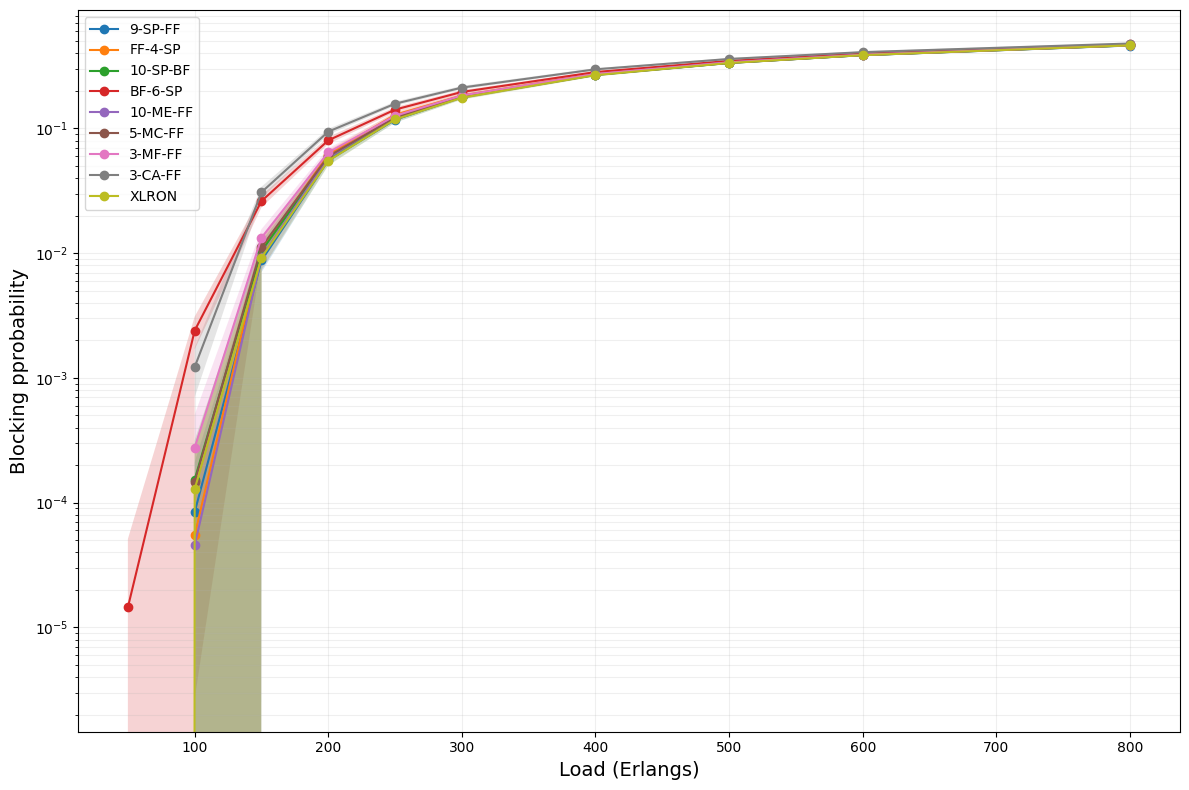

,Load,50,100,150,200,250,300,400,500,600,800
Heuristic,k,,,,,,,,,,
KSP-FF,10,0.0000,0.0000,0.0002,0.0028,0.0126,0.0307,0.0299,0.0795,0.1357,0.2359
FF-KSP,6,0.0000,0.0000,0.0000,0.0020,0.0146,0.0404,0.0374,0.0930,0.1514,0.2526
KSP-BF,10,0.0000,0.0000,0.0004,0.0052,0.0201,0.0457,0.0330,0.0828,0.1393,0.2403
BF-KSP,6,0.0000,0.0001,0.0020,0.0115,0.0352,0.0707,0.0521,0.1052,0.1604,0.2591
KME-FF,9,0.0000,0.0000,0.0000,0.0013,0.0111,0.0339,0.0329,0.0845,0.1410,0.2411
KMC-FF,9,0.0000,0.0000,0.0000,0.0015,0.0106,0.0306,0.0318,0.0820,0.1386,0.2380
KMF-FF,6,0.0000,0.0000,0.0001,0.0034,0.0166,0.0435,0.0399,0.0951,0.1544,0.2545
KCA-FF,2,0.0000,0.0003,0.0101,0.0325,0.0601,0.0941,0.0715,0.1231,0.1747,0.2654


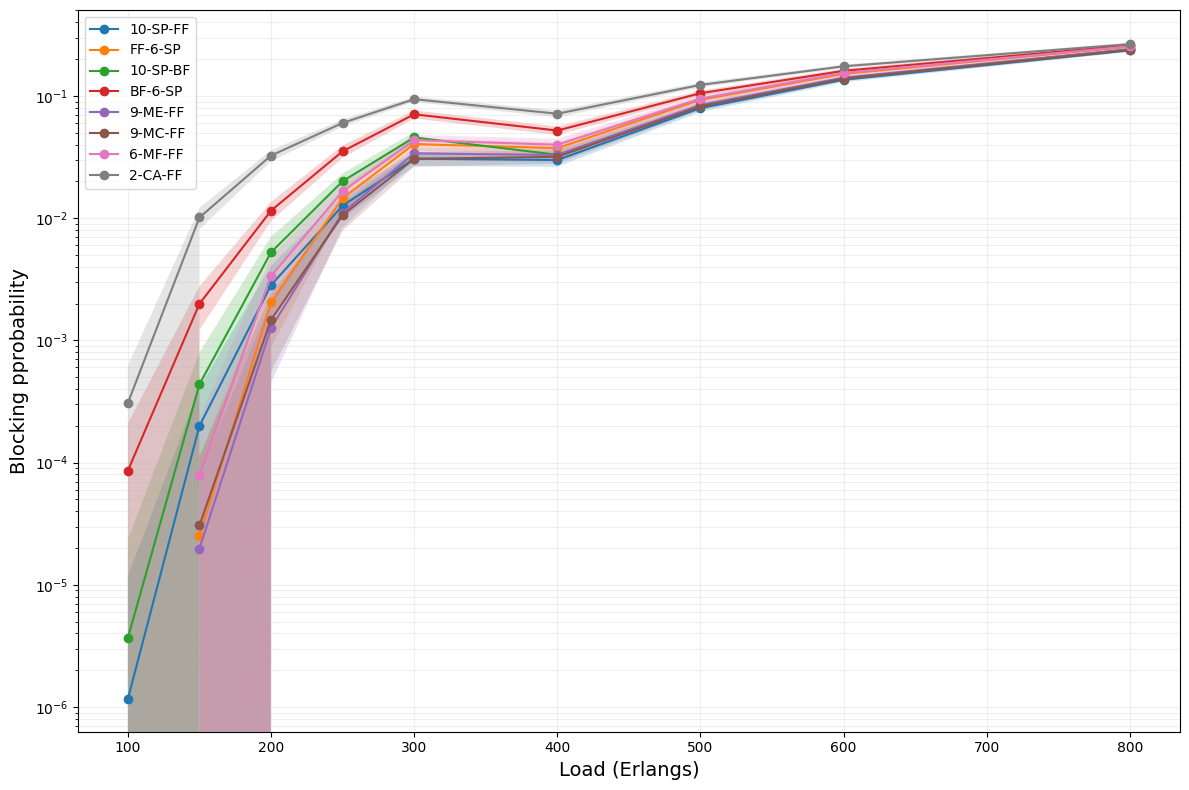

Tables and plots have been saved.


In [96]:
import matplotlib.pyplot as plt

convert_heuristic_name = lambda x: x[0].replace("K", f"{x[1]}-")


def plot_bp_vs_load(table, topology_name):
    plt.figure(figsize=(12, 8))
    
    # Extract BP Mean values
    bp_mean = table.xs('BP Mean', axis=1, level='Metric')
    bp_std = table.xs('BP Std', axis=1, level='Metric')
    
    # Get load values
    loads = bp_mean.columns.astype(int)
    
    # Plot each heuristic
    for heuristic in bp_mean.index:
        plt.plot(loads, bp_mean.loc[heuristic], marker='o', label=convert_heuristic_name(heuristic))
        # Plot std
        plt.fill_between(loads, bp_mean.loc[heuristic] - bp_std.loc[heuristic], bp_mean.loc[heuristic] + bp_std.loc[heuristic], alpha=0.2)

    # Get model eval data
    if topology_name == "NSFNET":
        model_eval = []
        for load in load_range:
            model_eval_file = f"/Users/michaeldoherty/git/XLRON/data/JOCN_SI/deeprmsa_model_eval/JOCN_DEEPRMSA_MASKED_8_1_{load}.csv"
            df = pd.read_csv(model_eval_file)
            mean_bp = df["service_blocking_probability"].mean()
            std_bp = np.sqrt(np.sum(df["service_blocking_probability_std"] ** 2) / len(df))
            model_eval.append([load, mean_bp, std_bp])
        
        model_eval_df = pd.DataFrame(model_eval, columns=['Load', 'BP Mean', 'BP Std'])
        plt.plot(model_eval_df['Load'], model_eval_df['BP Mean'], label='XLRON', marker='o')
        plt.fill_between(model_eval_df['Load'], model_eval_df['BP Mean'] - model_eval_df['BP Std'], model_eval_df['BP Mean'] + model_eval_df['BP Std'], alpha=0.2)
    
    plt.xlabel('Load (Erlangs)', fontsize=14)
    plt.ylabel('Blocking pprobability', fontsize=14)
    plt.xscale('linear')  # Use log scale for x-axis
    plt.yscale('log')  # Use log scale for y-axis
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(fontsize=10, loc='upper left')
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'bp_vs_load_{topology_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Assuming 'tables' is your list of DataFrames, one for each topology
topologies = ["NSFNET", "COST239"]  # Add your topology names here

for i, table in enumerate(tables):
    # Format and display the table
    table = keep_best_rows(table)
    styled_table = format_table_for_publication_html(table)
    display(styled_table)
    styled_table.to_html(f'formatted_table_rmsa_{i}.html')
    
    # Create the plot
    table = table.replace(0, np.nan)
    plot_bp_vs_load(table, topologies[i])

print("Tables and plots have been saved.")

,Load,50,100,150,200,250,300,400,500,600,800
Heuristic,k,,,,,,,,,,
KSP-FF,9,0.0000,0.0001,0.0088,0.0555,0.1175,0.1779,0.2687,0.3350,0.3866,0.4620
FF-KSP,4,0.0000,0.0001,0.0108,0.0618,0.1287,0.1837,0.2737,0.3421,0.3928,0.4679
KSP-BF,10,0.0000,0.0002,0.0104,0.0586,0.1210,0.1795,0.2697,0.3362,0.3878,0.4639
BF-KSP,6,0.0000,0.0024,0.0262,0.0802,0.1416,0.1960,0.2831,0.3476,0.3977,0.4721
KME-FF,10,0.0000,0.0000,0.0093,0.0584,0.1229,0.1811,0.2711,0.3384,0.3893,0.4649
KMC-FF,5,0.0000,0.0001,0.0112,0.0597,0.1222,0.1789,0.2696,0.3355,0.3869,0.4630
KMF-FF,3,0.0000,0.0003,0.0133,0.0642,0.1264,0.1835,0.2729,0.3385,0.3893,0.4651
KCA-FF,3,0.0000,0.0012,0.0308,0.0942,0.1578,0.2125,0.2977,0.3605,0.4087,0.4794


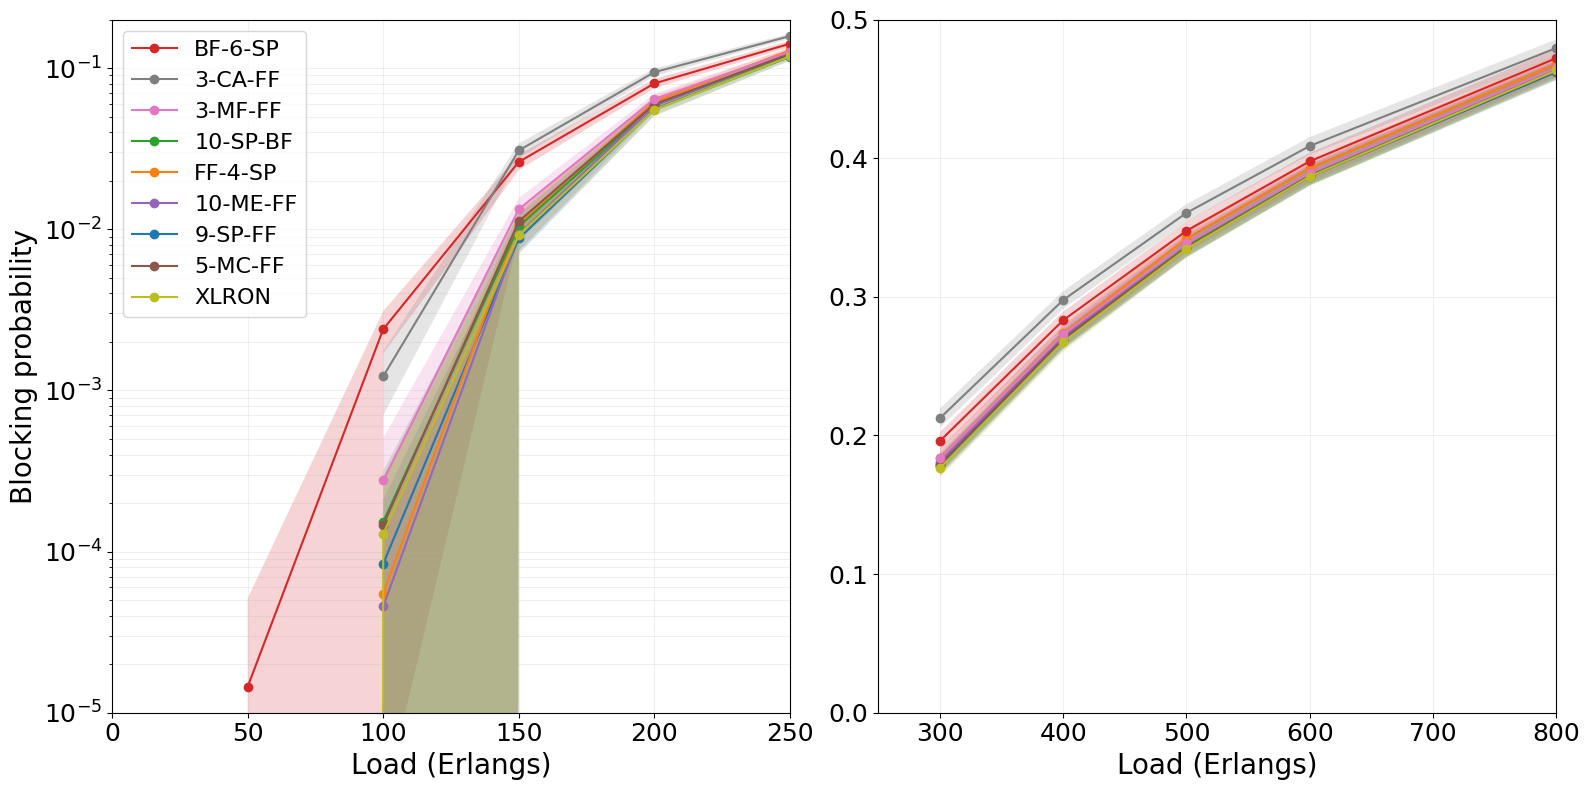

,Load,50,100,150,200,250,300,400,500,600,800
Heuristic,k,,,,,,,,,,
KSP-FF,10,0.0000,0.0000,0.0002,0.0028,0.0126,0.0307,0.0299,0.0795,0.1357,0.2359
FF-KSP,6,0.0000,0.0000,0.0000,0.0020,0.0146,0.0404,0.0374,0.0930,0.1514,0.2526
KSP-BF,10,0.0000,0.0000,0.0004,0.0052,0.0201,0.0457,0.0330,0.0828,0.1393,0.2403
BF-KSP,6,0.0000,0.0001,0.0020,0.0115,0.0352,0.0707,0.0521,0.1052,0.1604,0.2591
KME-FF,9,0.0000,0.0000,0.0000,0.0013,0.0111,0.0339,0.0329,0.0845,0.1410,0.2411
KMC-FF,9,0.0000,0.0000,0.0000,0.0015,0.0106,0.0306,0.0318,0.0820,0.1386,0.2380
KMF-FF,6,0.0000,0.0000,0.0001,0.0034,0.0166,0.0435,0.0399,0.0951,0.1544,0.2545
KCA-FF,2,0.0000,0.0003,0.0101,0.0325,0.0601,0.0941,0.0715,0.1231,0.1747,0.2654


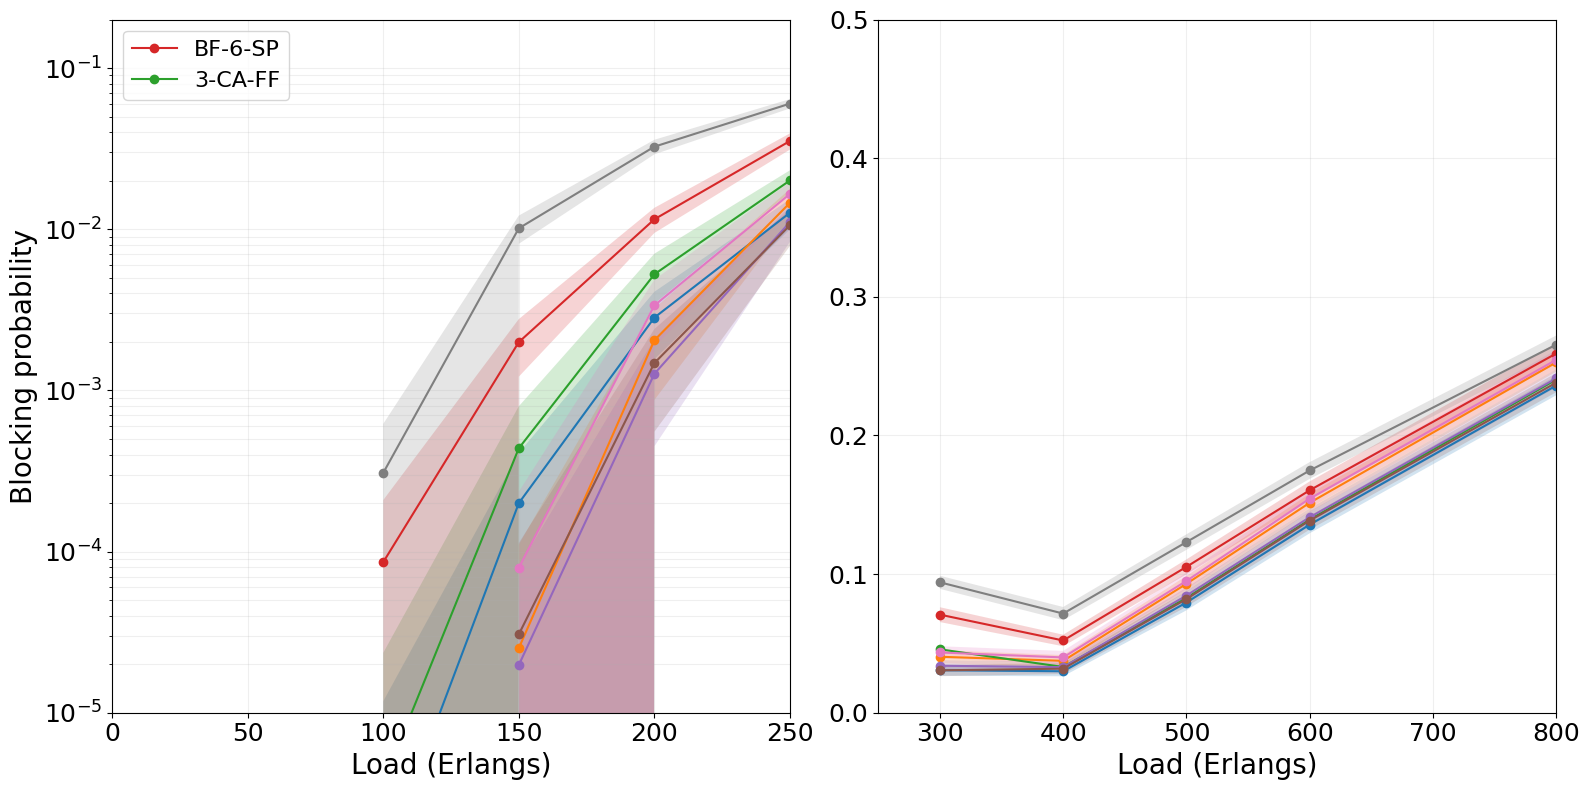

Tables and plots have been saved.


In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def convert_heuristic_name(x):
    return x[0].replace("K", f"{x[1]}-")

def plot_bp_vs_load(table, topology_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Extract BP Mean values
    bp_mean = table.xs('BP Mean', axis=1, level='Metric')
    bp_std = table.xs('BP Std', axis=1, level='Metric')
    
    # Get load values
    loads = bp_mean.columns.astype(int)

    legend_lines = {}
    # Plot each heuristic
    for heuristic in bp_mean.index:
        label = convert_heuristic_name(heuristic)
        # First subplot (0-250, log scale)
        mask1 = loads <= 250
        line, = ax1.plot(loads[mask1], bp_mean.loc[heuristic, mask1], marker='o', label=label)
        ax1.fill_between(loads[mask1], 
                         bp_mean.loc[heuristic, mask1] - bp_std.loc[heuristic, mask1], 
                         bp_mean.loc[heuristic, mask1] + bp_std.loc[heuristic, mask1], 
                         alpha=0.2)
        legend_lines[label] = line
        
        
        # Second subplot (250-800, linear scale)
        mask2 = loads > 250
        ax2.plot(loads[mask2], bp_mean.loc[heuristic, mask2], marker='o')
        ax2.fill_between(loads[mask2], 
                         bp_mean.loc[heuristic, mask2] - bp_std.loc[heuristic, mask2], 
                         bp_mean.loc[heuristic, mask2] + bp_std.loc[heuristic, mask2], 
                         alpha=0.2)

    # Get model eval data
    if topology_name == "NSFNET":
        model_eval = []
        for load in loads:
            model_eval_file = f"/Users/michaeldoherty/git/XLRON/data/JOCN_SI/deeprmsa_model_eval/JOCN_DEEPRMSA_MASKED_8_1_{load}.csv"
            df = pd.read_csv(model_eval_file)
            mean_bp = df["service_blocking_probability"].mean()
            std_bp = np.sqrt(np.sum(df["service_blocking_probability_std"] ** 2) / len(df))
            model_eval.append([load, mean_bp, std_bp])
        
        model_eval_df = pd.DataFrame(model_eval, columns=['Load', 'BP Mean', 'BP Std'])
        
        # First subplot
        mask1 = model_eval_df['Load'] <= 250
        line, = ax1.plot(model_eval_df.loc[mask1, 'Load'], model_eval_df.loc[mask1, 'BP Mean'], label='XLRON', marker='o')
        ax1.fill_between(model_eval_df.loc[mask1, 'Load'], 
                         model_eval_df.loc[mask1, 'BP Mean'] - model_eval_df.loc[mask1, 'BP Std'], 
                         model_eval_df.loc[mask1, 'BP Mean'] + model_eval_df.loc[mask1, 'BP Std'], 
                         alpha=0.2)
        legend_lines['XLRON']=line
        
        # Second subplot
        mask2 = model_eval_df['Load'] > 250
        ax2.plot(model_eval_df.loc[mask2, 'Load'], model_eval_df.loc[mask2, 'BP Mean'], marker='o')
        ax2.fill_between(model_eval_df.loc[mask2, 'Load'], 
                         model_eval_df.loc[mask2, 'BP Mean'] - model_eval_df.loc[mask2, 'BP Std'], 
                         model_eval_df.loc[mask2, 'BP Mean'] + model_eval_df.loc[mask2, 'BP Std'], 
                         alpha=0.2)
    
    # Configure subplots
    for ax in (ax1, ax2):
        ax.set_xlabel('Load (Erlangs)', fontsize=20)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        ax.tick_params(axis='both', which='major', labelsize=18)
    
    ax1.set_xlim(0, 250)
    ax1.set_yscale('log')
    ax2.set_xlim(250, 800)
    ax1.set_ylim(1e-5, 0.2)
    ax2.set_ylim(0, 0.5)
    
    # Set y-label only for the left subplot
    ax1.set_ylabel('Blocking probability', fontsize=20)

    # Add legend to the top left of the first subplot with custom order
    legend_order = ["BF-6-SP", "3-CA-FF", "3-MF-FF", "10-SP-BF", "FF-4-SP", "10-ME-FF", "9-SP-FF", "5-MC-FF", "XLRON"]
    ordered_legend = [legend_lines[label] for label in legend_order if label in legend_lines]
    ax1.legend(ordered_legend, ["BF-6-SP", "3-CA-FF", "3-MF-FF", "10-SP-BF", "FF-4-SP", "10-ME-FF", "9-SP-FF", "5-MC-FF", "XLRON"], fontsize=16, loc='upper left')
    
    # Add legend to the top left of the first subplot
    #ax1.legend(fontsize=16, loc='upper left')
    
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'bp_vs_load_{topology_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# The rest of your code remains the same
topologies = ["NSFNET", "COST239"]  # Add your topology names here

for i, table in enumerate(tables):
    # Format and display the table
    table = keep_best_rows(table)
    styled_table = format_table_for_publication_html(table)
    display(styled_table)
    styled_table.to_html(f'formatted_table_rmsa_{i}.html')
    
    # Create the plot
    table = table.replace(0, np.nan)
    plot_bp_vs_load(table, topologies[i])

print("Tables and plots have been saved.")



In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def format_table_for_publication(table):
    # Create a copy of the table with only BP Mean values
    mean_table = table.xs('BP Mean', axis=1, level='Metric')
    
    # Find the minimum value and its corresponding std for each load
    min_values = mean_table.min()
    min_indices = mean_table.idxmin()
    min_stds = pd.Series(index=min_values.index)
    for load in min_values.index:
        min_stds[load] = table.loc[min_indices[load], (load, 'BP Std')]
    
    return mean_table, min_values, min_stds

def create_styled_table_png(table, min_values, min_stds, filename, dpi=300):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, len(table) * 0.5))
    ax.axis('off')
    
    # Create the table
    table_obj = ax.table(cellText=table.values,
                         rowLabels=table.index,
                         colLabels=table.columns,
                         cellLoc='center',
                         loc='center')
    
    # Style the table
    table_obj.auto_set_font_size(False)
    table_obj.set_fontsize(9)
    table_obj.scale(1.2, 1.5)
    
    # Color the cells
    for (row, col), cell in table_obj.get_celld().items():
        if row == 0:  # Header
            cell.set_facecolor('#4472C4')
            cell.set_text_props(color='white')
        elif col == -1:  # Row labels
            cell.set_facecolor('#4472C4')
            cell.set_text_props(color='white')
        else:
            value = table.iloc[row-1, col]
            if value <= min_values[table.columns[col]] + min_stds[table.columns[col]]:
                cell.set_facecolor('#C6EFCE')
            else:
                cell.set_facecolor('#FFC7CE')
    
    # Add title
    plt.title('Blocking Probability (BP) for different heuristics and loads.\n'
              'Green cells are within one standard deviation of the minimum BP for that load.',
              fontsize=12, fontweight='bold', pad=20)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.5)
    plt.close()

# Assuming 'tables' is your list of DataFrames, one for each topology
for i, table in enumerate(tables):
    mean_table, min_values, min_stds = format_table_for_publication(table)
    create_styled_table_png(mean_table, min_values, min_stds, f'formatted_table_rmsa_topology_{i}.png')
    print(f"PNG table for topology {i} has been saved to 'formatted_table_rmsa_topology_{i}.png'")

print("\nAll tables have been saved as PNG images.")

PNG table for topology 0 has been saved to 'formatted_table_rmsa_topology_0.png'
PNG table for topology 1 has been saved to 'formatted_table_rmsa_topology_1.png'

All tables have been saved as PNG images.


In [16]:
import pandas as pd
import numpy as np

def format_heuristic(heuristic):
    return heuristic.upper().replace('_', '-')

env_type = "rwa_lightpath_reuse"
topologies = ["cost239", "nsfnet"]
heuristics = ['ksp_ff', 'ff_ksp']#, 'ksp_mu']#, 'ksp_mu_nonrel', 'ksp_mu_unique', 'mu_ksp', 'mu_ksp_nonrel', 'mu_ksp_unique']
num_requests_nsfnet = [1e4, 1e4, 1.5e4, 2e4, 2.5e4]
num_requests_cost239 = [2e4, 2e4, 2.5e4, 3e4, 3.5e4]
k_range = range(1, 11)
tables = []

for topology in topologies:
    data = []
    for heuristic in heuristics:
        for k in k_range:
            row = []
            num_requests_list = num_requests_nsfnet if topology == "nsfnet" else num_requests_cost239
            for i, num_requests in enumerate(num_requests_list):
                first_blocking = True if i == 0 else False
                df = read_rwa_lightpath_reuse_files(topology, heuristic, k, num_requests, first_blocking=first_blocking)
                accepted_services_mean = df["accepted_services"].mean()
                accepted_services_std = np.sqrt(np.sum(df["accepted_services_std"]**2)/len(df))
                row.extend([accepted_services_mean, accepted_services_std])
            data.append([format_heuristic(heuristic), k] + row)

    # Create multi-index DataFrame with titled columns
    num_requests_list[0] = "First Block"
    columns = ['Heuristic', 'k']
    for num_requests in num_requests_list:
        num_requests = f"{num_requests/1000:.0f}k" if num_requests != "First Block" else num_requests
        columns.extend([(num_requests, 'Accepted Services Mean'), (num_requests, 'Accepted Services Std')])
    
    table = pd.DataFrame(data, columns=columns)
    table = table.set_index(['Heuristic', 'k'])
    
    # Create a MultiIndex for the columns
    table.columns = pd.MultiIndex.from_tuples(table.columns, names=['# Requests', 'Metric'])
    
    tables.append(table)

# Example of how to display the table
print(tables[0])

# Requests              First Block                        \
Metric       Accepted Services Mean Accepted Services Std   
Heuristic k                                                 
KSP-FF    1             6605.030769            220.371800   
          2             7857.480000            261.317840   
          3            10436.533981            305.630400   
          4            10919.160000            277.986330   
          5            10650.390000            306.629270   
          6            12323.940000            287.524050   
          7            11988.680000            249.792830   
          8            11970.820000            243.627760   
          9            12291.500000            212.169340   
          10           12291.500000            212.169340   
FF-KSP    1             6605.030769            220.371800   
          2            12464.020000            185.438550   
          3            14324.460000            126.185130   
          4            1

In [17]:
import pandas as pd
import numpy as np

def format_table_for_publication(table):
    # Function to determine cell color
    
    def color_cell(value, max_value, max_std):
        if pd.isna(value):
            return ''
        if value >= max_value - max_std:
            return 'background-color: green; color: white'
        else:
            return 'background-color: red; color: white'
    
    # Create a copy of the table with only BP Mean values
    mean_table = table.xs('Accepted Services Mean', axis=1, level='Metric')
    
    # Find the minimum value and its corresponding std for each load
    max_values = mean_table.max()
    max_indices = mean_table.idxmax()
    max_stds = pd.Series(index=max_values.index)
    for num_requests in max_values.index:
        max_stds[num_requests] = table.loc[max_indices[num_requests], (num_requests, 'Accepted Services Std')]
    
    # Apply coloring
    styled_table = mean_table.style.apply(lambda col: [color_cell(v, max_values[col.name], max_stds[col.name]) for v in col], axis=0)
    
    # Format numbers
    styled_table = styled_table.format("{:.0f}")
    
    # Add a caption
    #styled_table = styled_table.set_caption("Blocking Probability (BP) for different heuristics and loads. Green cells are within one standard deviation of the minimum BP for that load.")
    
    return styled_table

# Assuming 'tables' is your list of DataFrames, one for each topology
for i, table in enumerate(tables):
    styled_table = format_table_for_publication(table)
    
    # Display the table (in a Jupyter notebook this will show the formatted table)
    display(styled_table)
    
    # Save to HTML (you can then copy this into your paper or convert to LaTeX)
    styled_table.to_html(f'formatted_table_rwalr_{i}.html')

# If you need LaTeX output, you can use a library like pandas_to_latex or manually convert the HTML

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def format_table_for_publication(table):
    # Create a copy of the table with only BP Mean values
    mean_table = table.xs('BP Mean', axis=1, level='Metric')
    
    # Find the minimum value and its corresponding std for each load
    min_values = mean_table.min()
    min_indices = mean_table.idxmin()
    min_stds = pd.Series(index=min_values.index)
    for load in min_values.index:
        min_stds[load] = table.loc[min_indices[load], (load, 'BP Std')]
    
    return mean_table, min_values, min_stds

def create_styled_table_png(table, min_values, min_stds, filename, dpi=300):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(20, len(table) * 0.5))
    ax.axis('off')
    
    # Create the table
    table_obj = ax.table(cellText=table.values,
                         rowLabels=table.index,
                         colLabels=table.columns,
                         cellLoc='center',
                         loc='center')
    
    # Style the table
    table_obj.auto_set_font_size(False)
    table_obj.set_fontsize(9)
    table_obj.scale(1.2, 1.5)
    
    # Color the cells
    for (row, col), cell in table_obj.get_celld().items():
        if row == 0:  # Header
            cell.set_facecolor('#4472C4')
            cell.set_text_props(color='white')
        elif col == -1:  # Row labels
            cell.set_facecolor('#4472C4')
            cell.set_text_props(color='white')
        else:
            value = table.iloc[row-1, col]
            if value <= min_values[table.columns[col]] + min_stds[table.columns[col]]:
                cell.set_facecolor('#C6EFCE')
            else:
                cell.set_facecolor('#FFC7CE')
    
    # Add title
    plt.title('Blocking Probability (BP) for different heuristics and loads.\n'
              'Green cells are within one standard deviation of the minimum BP for that load.',
              fontsize=12, fontweight='bold', pad=20)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.5)
    plt.close()

# Assuming 'tables' is your list of DataFrames, one for each topology
for i, table in enumerate(tables):
    mean_table, min_values, min_stds = format_table_for_publication(table)
    create_styled_table_png(mean_table, min_values, min_stds, f'formatted_table_rwalr_topology_{i}.png')
    print(f"PNG table for topology {i} has been saved to 'formatted_table_rwalr_topology_{i}.png'")

print("\nAll tables have been saved as PNG images.")

KeyError: 'BP Mean'

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# 
# def plot_blocking_prob_vs_load(table, heuristics, k_values, filename='blocking_prob_vs_load.png'):
#     plt.figure(figsize=(12, 8))
#     for heuristic in heuristics:
#         for k in k_values:
#             data = table.loc[heuristic, (k, slice(None), 'mean')]
#             plt.plot(load_range, data.values, label=f'{heuristic}, k={k}', marker='o')
#     
#     plt.xlabel('Load')
#     plt.ylabel('Blocking Probability')
#     plt.title('Blocking Probability vs Load for Different Heuristics and k Values')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()
# 
# def plot_heatmap(table, filename='blocking_prob_heatmap.png'):
#     mean_data = table.xs('mean', level='BP', axis=1)
#     plt.figure(figsize=(15, 10))
#     sns.heatmap(mean_data, cmap='YlOrRd', annot=True, fmt='.2e', cbar_kws={'label': 'Blocking Probability'})
#     plt.title('Heatmap of Blocking Probability for Different Heuristics, k Values, and Loads')
#     plt.tight_layout()
#     plt.show()
# 
# def plot_box_plot(table, filename='blocking_prob_box_plot.png'):
#     # Select only the 'mean' values and reset the index
#     data_mean = table.xs('mean', level='BP', axis=1).stack().reset_index()
#     data_mean.columns = ['Heuristic', 'k', 'load', 'Blocking Probability']
#     
#     plt.figure(figsize=(15, 8))
#     sns.boxplot(x='Heuristic', y='Blocking Probability', data=data_mean)
#     plt.xticks(rotation=45)
#     plt.title('Distribution of Blocking Probability for Different Heuristics')
#     plt.tight_layout()
#     plt.show()
# 
# # Usage
# for i, table in enumerate(tables):
#     plot_blocking_prob_vs_load(table, heuristics[:3], [1, 5, 10], f'blocking_prob_vs_load_{topologies[i]}.png')
#     plot_heatmap(table, f'blocking_prob_heatmap_{topologies[i]}.png')
#     plot_box_plot(table, f'blocking_prob_box_plot_{topologies[i]}.png')
# 
# # For comparing topologies:
# fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# for i, topology in enumerate(topologies):
#     mean_data = tables[i].xs('mean', level='BP', axis=1)
#     sns.heatmap(mean_data, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Blocking Probability'}, ax=axes[i])
#     axes[i].set_title(f'Blocking Probability Heatmap for {topology}')
# plt.tight_layout()
# plt.show()